Simulate a data set to test the completeness model, etc.

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

import matplotlib.pyplot as plt
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from astropy.io import ascii

from dr25 import dr25

/Users/ruthangus/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Set the property you're investigating.

In [2]:
p = "kepmag"

In [3]:
# Instigate the TensorFlow Session
session = tf.InteractiveSession()

# Select the CDPP columns needed for calculating the detection efficiency.
durations = np.array([1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 6.0, 7.5, 9.0, 10.5, 12.0, 12.5, 15.0])
cdpp_cols = ["rrmscdpp01p5", "rrmscdpp02p0", "rrmscdpp02p5", "rrmscdpp03p0",
             "rrmscdpp03p5", "rrmscdpp04p5", "rrmscdpp05p0", "rrmscdpp06p0",
             "rrmscdpp07p5", "rrmscdpp09p0", "rrmscdpp10p5", "rrmscdpp12p0",
             "rrmscdpp12p5", "rrmscdpp15p0"]

# Select the columns you need for the stellar parameters you care about.
# Note - rad comes from the Berger catalogue.
stlr_cols = cdpp_cols + ["kepid", "rad", "teff", "logg", "dataspan", "dutycycle", "gamma1", "gamma2", p, "nconfp"]

# Select limits on the planet population you're interested in. 
min_prad = .5
max_prad = 15
min_period = 1.0
max_period = 100.0
#min_p = np.exp(-.5) # Jz
#max_p = np.exp(3)

#min_p = 4100
#max_p = 6200

min_p = 11.5
max_p = 16.5

Load the KIC

In [4]:
experiment_name = "sunlike_short_period"
dirname = os.path.join("experiments", experiment_name)

with open(os.path.join(dirname, "params.json"), "r") as f:
    params = json.load(f)
    
with open(os.path.join(dirname, "robo.json"), "r") as f:
    robo = json.load(f)
    
with open(os.path.join(dirname, "pdet_model.json"), "r") as f:
    pdet_model = json.load(f)
    
# Load the KIC stellar catalogue and the catalogue of actions.
stlr = pd.read_csv(os.path.join(dirname, "stlr.csv"))
actions = pd.read_csv(os.path.join("data", "stlr_gaia_actions.csv"))
print("Total number of stars in stlr: {0}".format(len(stlr)))
print("Total number of stars in stlr_gaia_actions: {0}".format(len(actions)))

stlr = pd.merge(stlr, actions, on="kepid", suffixes=("", "_gaia"), how="inner")
stlr["kepid"] = stlr.KIC
print("Total number of stars in join: {0}".format(len(stlr)))

print("min = ", min(stlr["{}".format(p)]), "max", max(stlr["{}".format(p)]))

m = stlr["{}".format(p)] < max_p
m &= stlr["{}".format(p)] > min_p
m &= stlr.logg > 4.2
m &= stlr.rad < 1.15

# Get rid of misclassified subgiants by doing a cut on absolute magnitude.
M = - 5*np.log10(stlr.r_est.values) + 5 + stlr.phot_g_mean_mag.values
m &= 5 < M

stlr = pd.DataFrame(stlr[m])
print("Total number of stars after restricting J_z & logg: {0}".format(len(stlr)))

Total number of stars in stlr: 54837
Total number of stars in stlr_gaia_actions: 85492
Total number of stars in join: 52106
min =  7.364 max 17.343
Total number of stars after restricting J_z & logg: 40067


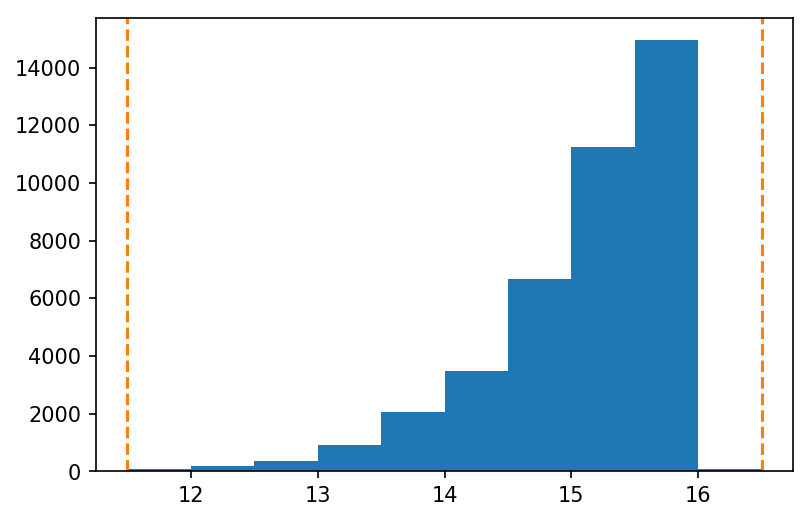

In [5]:
plt.hist(stlr["{}".format(p)])
plt.axvline(min_p, color="tab:orange", ls="--")
plt.axvline(max_p, color="tab:orange", ls="--")

Now I want to simulate a catalogue where exoplanet occurrence rate ONLY decreases with planet radius.

In [6]:
kois = ascii.read("data/q1_q17_dr25_koi.txt").to_pandas()
kois = pd.merge(kois, stlr[stlr_cols], on="kepid")
    
prad = kois.koi_ror * kois.rad / 0.009158

m = kois.koi_pdisposition == "CANDIDATE"
m &= kois.koi_period < max_period
m &= kois.koi_period > min_period
m &= prad < max_prad
m &= prad > min_prad

kois["prad"] = prad

kois = pd.DataFrame(kois[m])
print("selected {0} KOIs".format(len(kois)))

selected 1155 KOIs


In [45]:
# Assign planets to stars at random.
nplanets = int(len(stlr))
seed = 42
inds = np.random.randint(len(stlr), size=nplanets) #len(kois))

# kois = stlr
inds = range(len(stlr))

fake_kois = pd.DataFrame(dict({}))

for col in stlr_cols:
    fake_kois["{}".format(col)] = np.array(stlr["{}".format(col)])[inds]

for col in cdpp_cols:
    fake_kois["{}".format(col)] = np.array(stlr["{}".format(col)])[inds]

# Uniform distribution over planet period.
fake_kois["koi_period"] = np.random.uniform(min_period, max_period, nplanets)

fake_kois["prad"] = np.random.uniform(min_period, max_period, nplanets)


# Small planets are rarer than large planets.
# m = 0
# if int(nplanets*2/3)+int(nplanets/3) < nplanets:
#     m = 1
# small = np.random.uniform(min_prad, max_prad/2, int(nplanets/3))
# big = np.random.uniform(max_prad/2, max_prad, int(nplanets*2/3)+m)
    
# fake_kois["prad"] = np.concatenate((small, big))
# fake_kois = kois

Now the distribution of stellar properties should be identical to the distribution of planet properties.

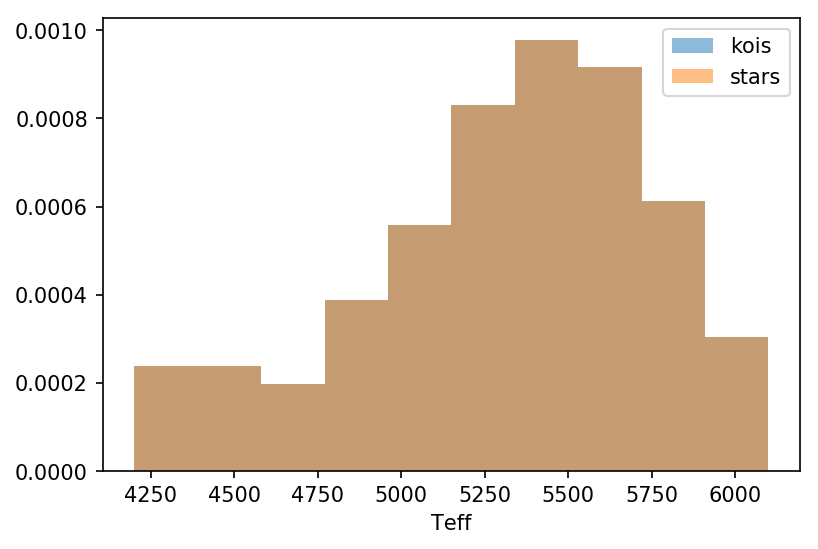

In [46]:
plt.hist(fake_kois.teff.values, 10, normed=True, alpha=.5, label="kois")
plt.hist(stlr.teff.values, 10, normed=True, alpha=.5, label="stars")
plt.xlabel("Teff")
plt.legend()

Uniform distribution over periods.

Text(0.5,0,'KOI period [days]')

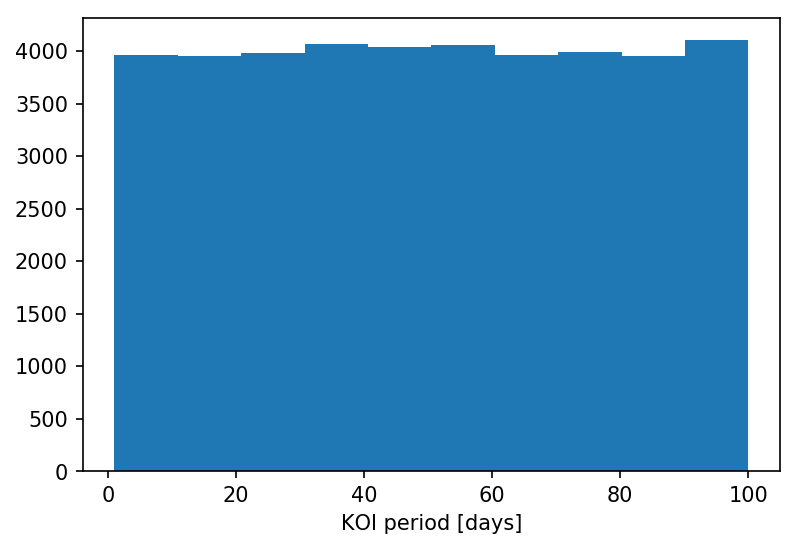

In [47]:
plt.hist(fake_kois.koi_period, 10)
plt.xlabel("KOI period [days]")

Step function over radius.

Text(0.5,0,'KOI radius [R_earth]')

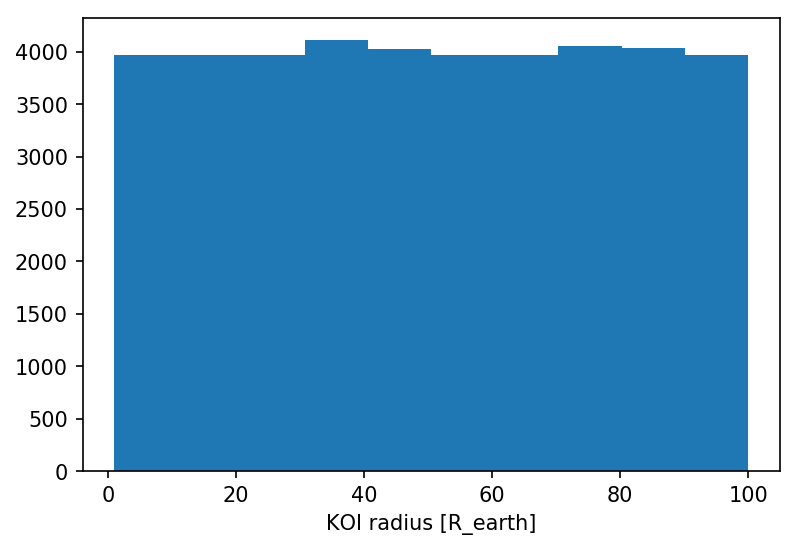

In [48]:
plt.hist(fake_kois.prad, 10)
plt.xlabel("KOI radius [R_earth]")

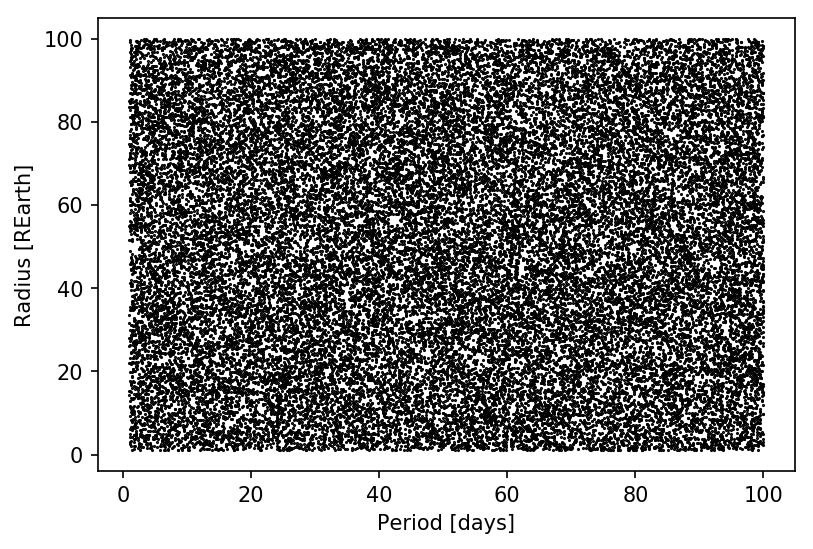

In [49]:
plt.plot(fake_kois.koi_period, fake_kois.prad, ".k", ms=1)
plt.xlabel("Period [days]")
plt.ylabel("Radius [REarth]");

In [50]:
T = tf.float64

R_star = tf.placeholder(T, (None,), name="R_star")
logg_star = tf.placeholder(T, (None,), name="logg_star")
gamma_star = tf.placeholder(T, (None, 2), name="gamma_star")
cdpp_star = tf.placeholder(T, (None, len(durations)), name="cdpp_star")
dataspan_star = tf.placeholder(T, (None,), name="dataspan_star")
dutycycle_star = tf.placeholder(T, (None,), name="dutycycle_star")
R_pl = tf.placeholder(T, (None,), name="R_pl")
P_pl = tf.placeholder(T, (None,), name="P_pl")
b_pl = tf.placeholder(T, (None,), name="b_pl")

# Completeness model
comp_norm = tf.Variable(pdet_model["comp_norm"], dtype=T, name="comp_norm")
mes0_p = tf.Variable(pdet_model["mes0"], dtype=T, name="mes0")
log_sig_mes_p = tf.Variable(pdet_model["log_sigma_mes"], dtype=T, name="log_sig_mes")

# Estimate the transit properties
ror_pl = 0.009158 * R_pl / R_star
M_star = 10.0**(logg_star-4.437) * tf.square(R_star)
a_pl = 215.0 * M_star**(1.0/3.0) * (P_pl/365.25)**(2.0/3.0)
a_pl = tf.clip_by_value(a_pl, R_star, a_pl)
arg = tf.square(a_pl) - tf.square(R_star * b_pl)
a_pl_sin_i = tf.sqrt(tf.clip_by_value(arg, tf.zeros_like(arg), arg))
arg = (1.0+ror_pl)**2-b_pl**2
arg = tf.clip_by_value(arg, tf.zeros_like(arg), arg)
arg = R_star * tf.sqrt(arg) / a_pl_sin_i
arg = tf.clip_by_value(arg, -1.0+1e-5, 1.0-1e-5)
tau_tot = P_pl * tf.asin(arg) / np.pi
arg = (1.0-ror_pl)**2-b_pl**2
arg = tf.clip_by_value(arg, tf.zeros_like(arg), arg)
arg = R_star * tf.sqrt(arg) / a_pl_sin_i
arg = tf.clip_by_value(arg, -1.0+1e-5, 1.0-1e-5)
tau_full = P_pl * tf.asin(arg) / np.pi
shape_pl = tau_full / tau_tot
tau_pl = 0.5 * (tau_tot + tau_full)

depth = (1.0 - dr25.quad(gamma_star[:, 0], gamma_star[:, 1], ror_pl, b_pl)) * 1e6

# The completeness model should be a function of shape
x = shape_pl
x2 = tf.square(x)
mes0 = mes0_p[0] + mes0_p[1] * x + mes0_p[2] * x2
log_sig_mes = log_sig_mes_p[0] + log_sig_mes_p[1] * x + log_sig_mes_p[2] * x2

# Interpolate the CDPP grid
cdpp = dr25.interp(tau_full, durations, cdpp_star)

# Estimate the MES
ntran = dataspan_star * dutycycle_star / P_pl
mes = tf.sqrt(ntran) * depth / cdpp

# Completeness as a function of MES
pdet = comp_norm / (1.0 + tf.exp(-(tf.log(mes) - tf.log(mes0)) * tf.exp(-log_sig_mes)))
pdet = tf.clip_by_value(pdet, 0.0, 1.0)

# Compute the window function
M = dataspan_star / P_pl
f = dutycycle_star
omf = 1.0 - f
pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
msk = tf.logical_and(pw >= 0.0, M >= 2.0)
pwin = tf.where(msk, pw, tf.zeros_like(pw))

# And the geometric transit prob
pgeom = R_star / a_pl
pgeom = tf.clip_by_value(pgeom, 0.0, 1.0)
# 1. / (aor * (1 - e*e)) * (aor > 1.0)

pdet_tot = pdet * pwin * pgeom * robo["eff"]

session.run(tf.global_variables_initializer())

In [51]:
seed = 42
np.random.seed(seed)
Nint = 500000
N = len(stlr)
inds = np.random.randint(N, size=Nint)
rp = np.exp(np.random.uniform(np.log(min_prad), np.log(max_prad), Nint))
period = np.exp(np.random.uniform(np.log(min_period), np.log(max_period), Nint))
log_p = np.log(np.array(stlr["{}".format(p)]))[inds]
lin_p = np.array(stlr["{}".format(p)])[inds]
teff = np.array(stlr.teff)[inds]

feed = {
    R_star: np.array(stlr.rad)[inds],
    logg_star: np.array(stlr.logg)[inds],
    gamma_star: np.array(stlr[["gamma1", "gamma2"]])[inds],
    cdpp_star: np.array(stlr[cdpp_cols])[inds],
    dataspan_star: np.array(stlr.dataspan)[inds],
    dutycycle_star: np.array(stlr.dutycycle)[inds],
    R_pl: rp,
    P_pl: period,
    b_pl: np.random.rand(Nint),
}

Q = session.run(pdet_tot, feed_dict=feed)

In [52]:
nbins = 5
log_p_bins = np.linspace(np.log(min_p), np.log(max_p), nbins+1)
lin_p_bins = np.linspace(min_p, max_p, nbins+1)

num, _ = np.histogram(log_p, log_p_bins, weights=Q)
denom, _ = np.histogram(log_p, log_p_bins)
N_det, _ = np.histogram(np.log(np.array(fake_kois["{}".format(p)])), log_p_bins)

norm, _ = np.histogram(np.log(np.array(stlr["{}".format(p)])), log_p_bins)
# area = log_jz_bins[1] - log_jz_bins[0]

gammas = N_det * denom / num / norm
gamma_errs = gammas / np.sqrt(N_det)

Text(0.5,0,'kepmag')

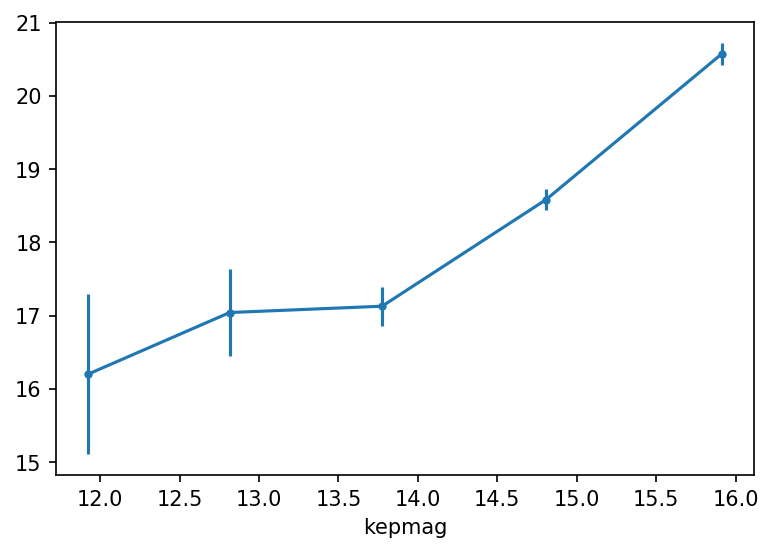

In [53]:
x = 0.5 * (log_p_bins[1:] + log_p_bins[:-1])
plt.errorbar(np.exp(x), gammas, yerr=gamma_errs, fmt=".-")
plt.xlabel("{}".format(p))

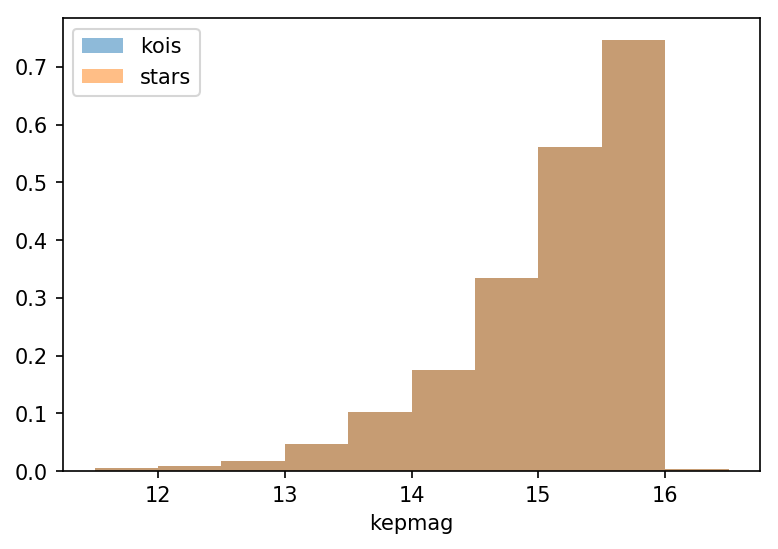

In [55]:
hist1, b, _ = plt.hist(fake_kois.kepmag.values, 10, normed=True, alpha=.5, label="kois")
hist2, b, _ = plt.hist(stlr.kepmag.values, bins=b, normed=True, alpha=.5, label="stars")
plt.xlabel("kepmag")
plt.legend()

Text(0,0.5,'koi kepmag - stlr kepmag')

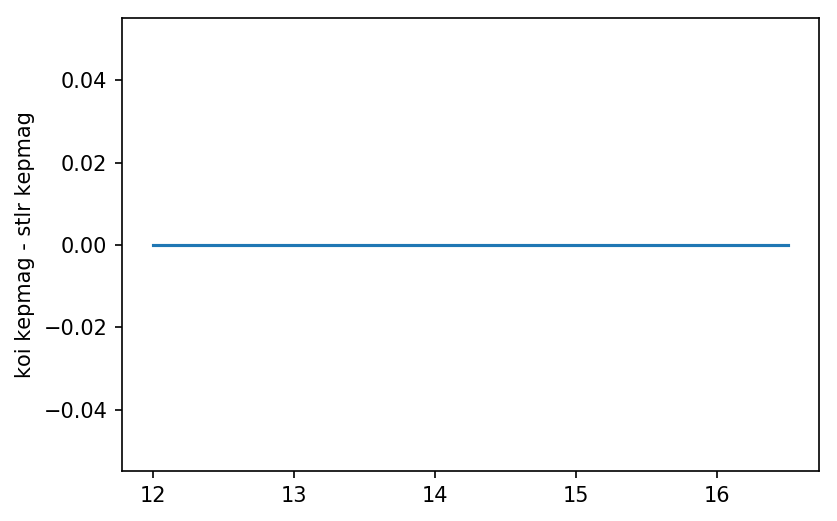

In [56]:
#h1, b = np.histogram(fake_kois.kepmag.values, 10)
#h2, b = np.histogram(stlr.kepmag.values, bins=b)

#plt.step(b[1:], h1/h2)
err1, err2 = np.sqrt(h1), np.sqrt(h2)
err = np.sqrt(err1**2 + err2**2)
#plt.errorbar(b[1:], h1/h2, yerr=err1, fmt=".", color="tab:blue")

plt.step(b[1:], hist1-hist2)
plt.ylabel("koi kepmag - stlr kepmag")

Occurrence rate as a function of planet radius.

In [57]:
seed = 42
np.random.seed(seed)
Nint = 500000
N = len(kois)
inds = np.random.randint(N, size=Nint)
rp = np.exp(np.random.uniform(np.log(min_prad), np.log(max_prad), Nint))
period = np.exp(np.random.uniform(np.log(min_period), np.log(max_period), Nint))
log_r = np.log(np.array(fake_kois.prad))[inds]
lin_r = np.array(fake_kois.prad)[inds]
teff = np.array(stlr.teff)[inds]

feed = {
    R_star: np.array(stlr.rad)[inds],
    logg_star: np.array(stlr.logg)[inds],
    gamma_star: np.array(stlr[["gamma1", "gamma2"]])[inds],
    cdpp_star: np.array(stlr[cdpp_cols])[inds],
    dataspan_star: np.array(stlr.dataspan)[inds],
    dutycycle_star: np.array(stlr.dutycycle)[inds],
    R_pl: rp,
    P_pl: period,
    b_pl: np.random.rand(Nint),
}

Q = session.run(pdet_tot, feed_dict=feed)

In [58]:
nbins = 10
log_r_bins = np.linspace(np.log(min_prad), np.log(max_prad), nbins+1)
lin_r_bins = np.linspace(min_prad, max_prad, nbins+1)

# num, _ = np.histogram(log_r, log_r_bins, weights=Q)
# denom, _ = np.histogram(log_r, log_r_bins)
# N_det, _ = np.histogram(np.log(np.array(fake_kois["prad"])), log_r_bins)
# norm = len(stlr)

num, _ = np.histogram(lin_r, lin_r_bins, weights=Q)
denom, _ = np.histogram(lin_r, lin_r_bins)
N_det, _ = np.histogram(np.array(fake_kois["prad"]), lin_r_bins)
norm = len(stlr)

gammas = N_det * denom / num / norm
gamma_errs = gammas / np.sqrt(N_det)

[0.18312163 0.26987265 0.28655167 0.27350103 0.27498305 0.3111722
 0.30358261 0.28183449 0.27422804 0.267744  ]
[ 5635  5875 11927  5781  7137 10132  7797  7954  5478  5664] 

[290.30817047 311.32701018 633.68187455 291.20327248 354.3319103
 495.72108808 385.88714441 409.94690299 268.72750104 305.6998609 ] 



Text(0.5,0,'KOI radius')

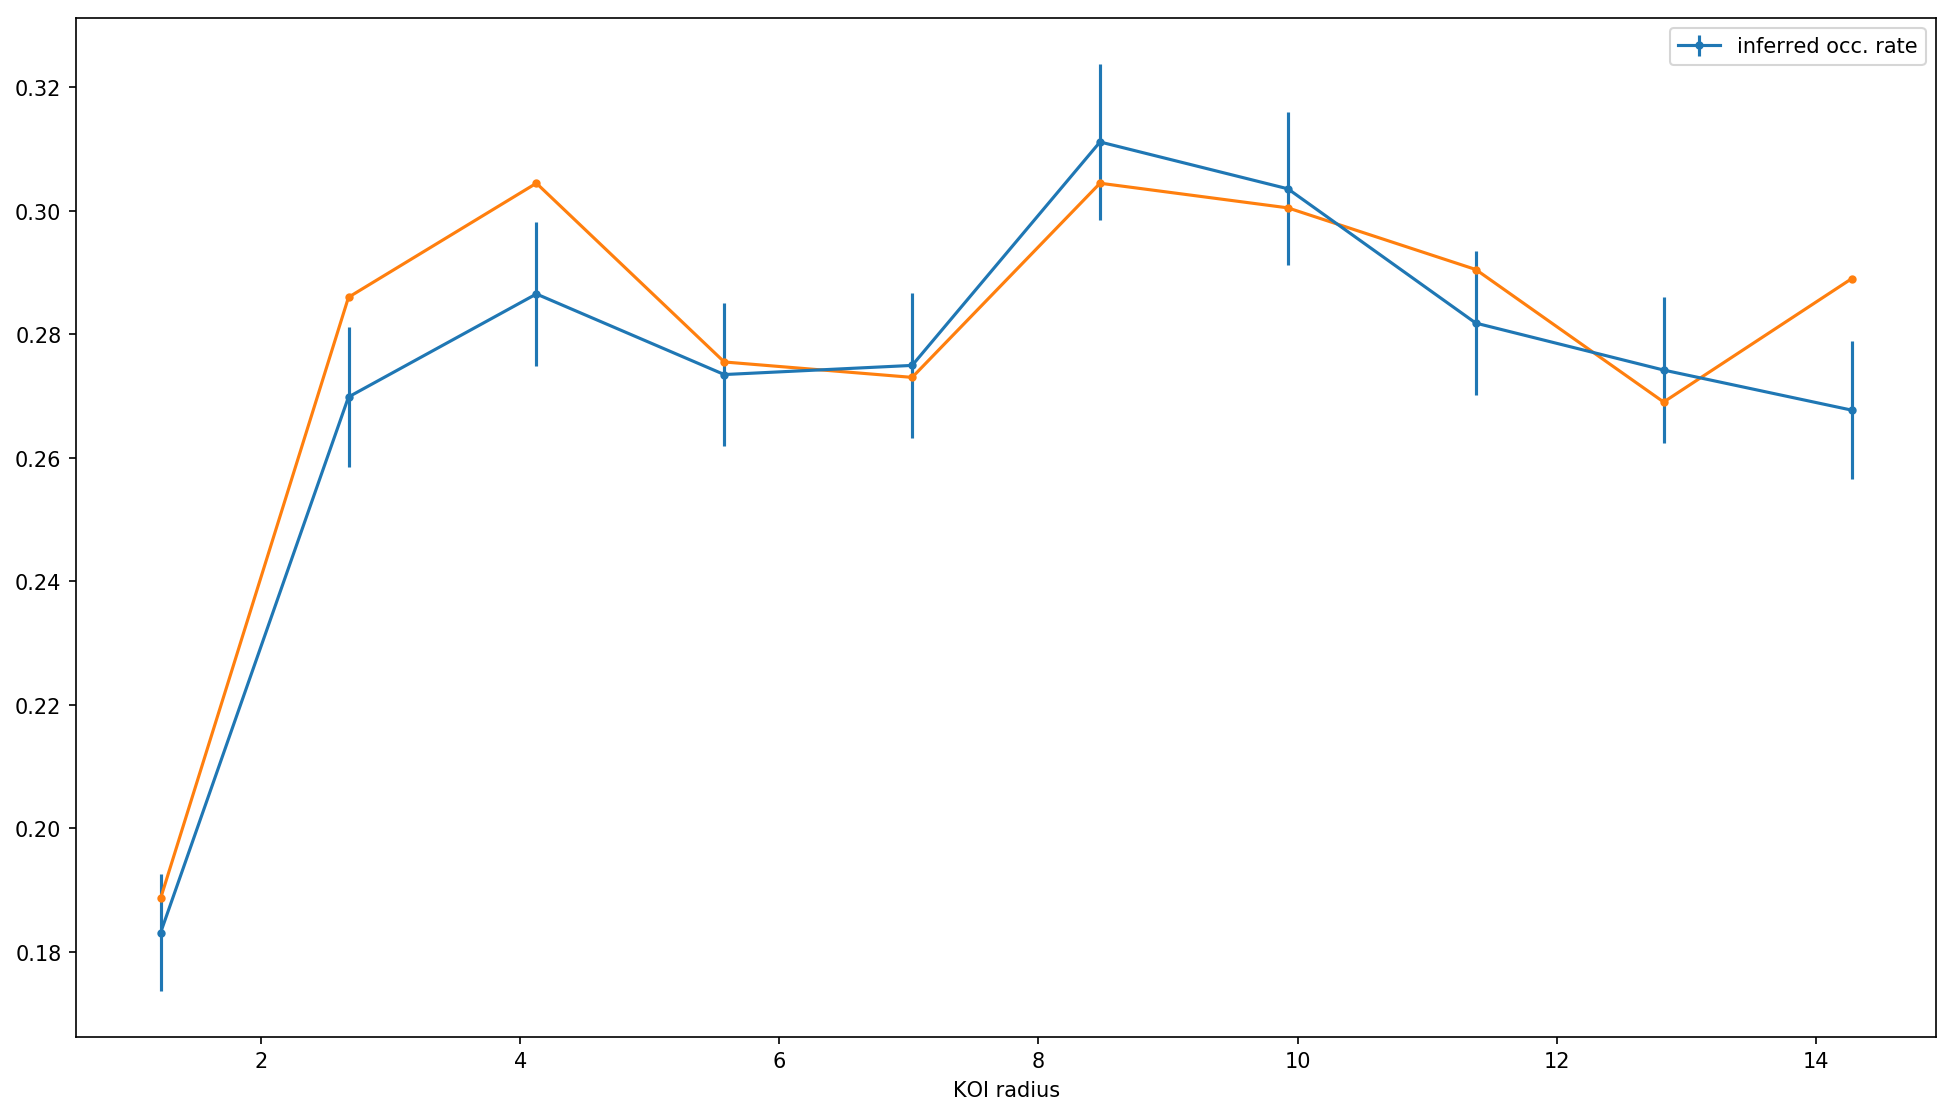

In [59]:
plt.figure(figsize=(16, 9))
# x = 0.5 * (log_r_bins[1:] + log_r_bins[:-1])
x = 0.5 * (lin_r_bins[1:] + lin_r_bins[:-1])
plt.errorbar(x, gammas, yerr=gamma_errs, fmt=".-", label="inferred occ. rate")
plt.xlabel("prad")

print(gammas)
print(denom, "\n")
print(num, "\n")

#hist, bins = np.histogram(fake_kois.prad, bins=np.exp(log_r_bins), normed=True)
hist, _ = np.histogram(fake_kois.prad, bins=lin_r_bins)
plt.plot(x, hist/len(stlr)*20, ".-")
#plt.step(0.5 * (bins[1:] + bins[:-1]), hist/len(stlr)*20)
plt.legend()
plt.xlabel("KOI radius")



Text(0.5,0,'KOI radius')

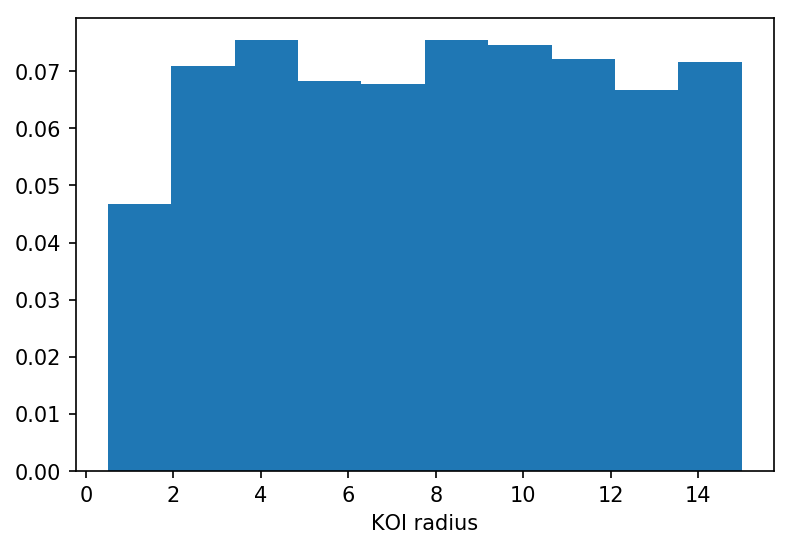

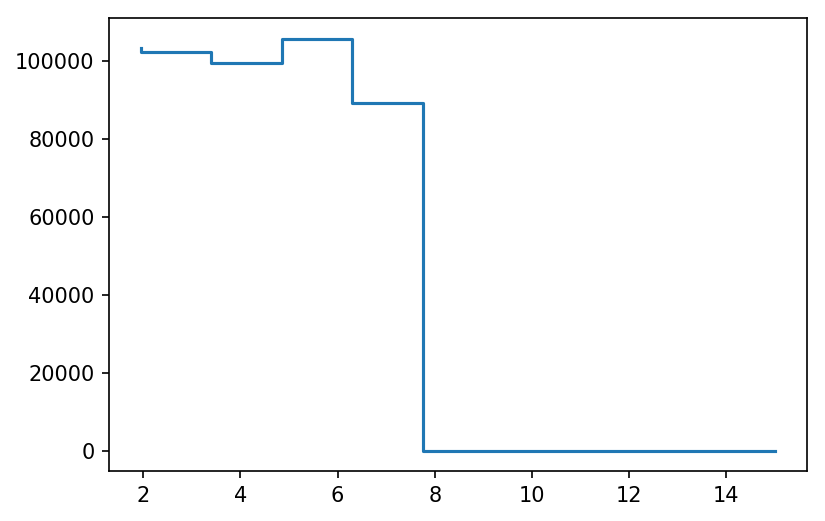

In [34]:
plt.step(lin_r_bins[1:], denom)